# 2. `GPyOpt`によるベイズ最適化

In [1]:
import sys
sys.path.append("/Users/gonakazawa/.pyenv/versions/3.10.6/lib/python3.10/site-packages")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

## 2.1 1次元の場合の例

### 課題設定

次の関数の最小値を求める問題をベイズ最適化で解いてみましょう。この関数はForrester関数といって、最適化のデモによく用いられる関数のひとつのです。

$$
\begin{align*}
f(x) &= (6x-2)^2\sin(12x-4), 0\leq x\leq1
\end{align*}
$$

In [3]:
def forrester(x):
    return (6*x-2)**2 * np.sin(12*x - 4)

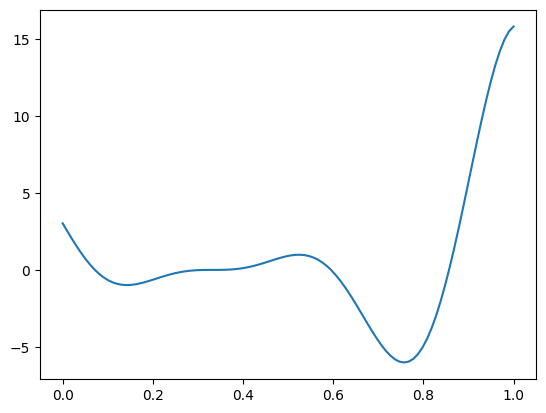

In [4]:
x = np.linspace(start = 0, stop = 1, num = 100)
plt.plot(x, forrester(x))
plt.show()

### 設定の仕方

まず最適化したい変数の名前、連続変数かカテゴリー変数か、値の範囲を指定します。

In [5]:
domain = [{"name" : "x", "type" : "continuous", "domain" : (0, 1)}]

次にどんなカーネルを用いるかを指定します。

In [6]:
kernel = GPy.kern.Matern52(input_dim = 1)

そして、`GPyOpt.methods`モジュールの`BaysianOptimization`クラスで

* f : 最適化したい関数
* domain : 最適化する変数の設定
* kernel : 用いるカーネルの指定（なにも指定しない場合はMarten 5/2。）
* acquisition_type : 獲得関数の設定（"MPI","EI","LCB"が選択できる。デフォルトはEI。）
* exact_feval : 得られる観測値にノイズはつかないか？

を指定し、インスタンスをたてます。なお、デフォルトは最小化ですが、`maximize=True`で最大化問題に切り替えることができます。

In [7]:
opt = BayesianOptimization(f = forrester, 
                           domain = domain,
                           kernel = kernel, 
                           acquisition_type = "EI",
                           exact_feval = True)    # ノイズなし

あとは、`run_optimization`メソッドで最適解を計算します。ここで、`max_iter`に数を指定することで繰り返しの最大回数を指定できます。

In [8]:
opt.run_optimization(max_iter = 15)

得られた最適解と最適値は、それぞれ`x_opt`と`fx_opt`アトリビュートで確認できます。

In [9]:
opt.x_opt, opt.fx_opt

(array([0.75737229]), -6.020731903579095)

計算の収束のようすは、横軸に繰り返しのラウンド数、縦軸に前のラウンドの関数の値との差や現状得られている最適値のグラフをかくことで確認できます。

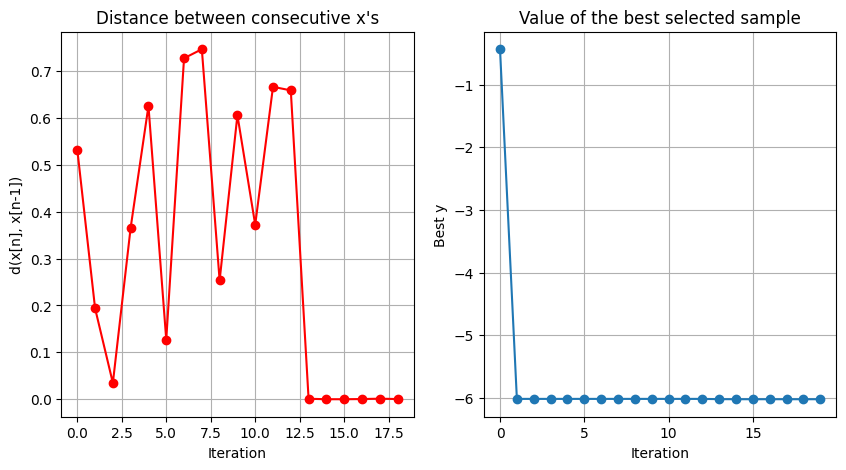

In [11]:
opt.plot_convergence()

また獲得関数を図示することも、収束のようすを確認するうえでは参考になります。

TypeError: _AxesBase._process_unit_info() got an unexpected keyword argument 'xdata'

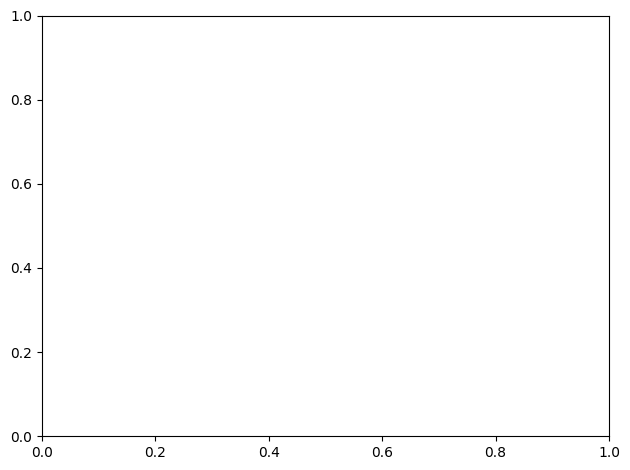

In [12]:
opt.plot_acquisition()

## 2.2 2次元の場合の例

### 課題設定

次の関数の最小値を求める問題をベイズ最適化で解いてみましょう。この関数はSix-Hump camel関数といって、最適化のデモによく用いられる関数のひとつのです。

$$
\begin{align*}
f(x_1,x_2) &= \left(4-2.1x_1^2+\frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + (-4+4x_2^2)x_2^2\\
&-3\leq x_1\leq3, -2\leq x_2\leq2
\end{align*}
$$

なお今回は、観測値はノイズつきで得られるとします。

**Remark**　この最適解は$(0.0898,−0.7126)$と$(−0.0898,0.7126)$の2箇所に存在します。

In [13]:
def sixhumpcamel(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    return (4-2.1*x1**2+x1**4/3)*x1**2 + x1*x2 + (-4+4*x2**2)*x2**2

`np.random.normal(loc = 期待値, scale = 標準偏差, size = データ点の個数)`

In [14]:
def sixhumpcamel_data(x, sd = 0.1):
    return sixhumpcamel(x) + np.random.normal(loc = 0, 
                                              scale = sd, 
                                              size = x.shape[0])

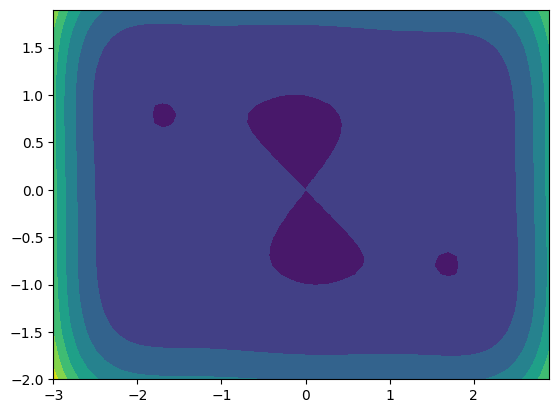

In [15]:
x = np.arange(-3, 3, 0.1)
y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(x, y)
XY = np.array([X.ravel(), Y.ravel()]).T
Z = sixhumpcamel(XY).reshape(X.shape)

plt.contourf(X, Y, Z)
plt.show()

### 最適化の計算

In [38]:
domain = [{"name" : "x1", "type" : "continuous", "domain" : (-3, 3)}, 
          {"name" : "x2", "type" : "continuous", "domain" : (-2, 2)}]

In [39]:
kernel = GPy.kern.Matern52(input_dim = 2)

In [45]:
opt = BayesianOptimization(f = sixhumpcamel_data, 
                           domain = domain, 
                           kernel = kernel,
                           acquisition_type = "EI", 
                           exact_feval = False)    # ノイズあり

In [46]:
opt.run_optimization(max_iter = 60)

In [47]:
opt.x_opt, opt.fx_opt

(array([-0.16395536,  0.71811151]), -1.1735086717208039)

### 収束の様子の確認

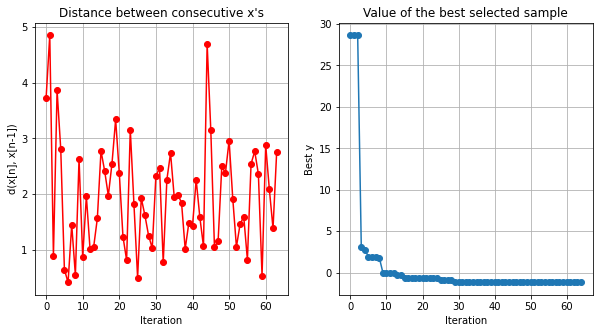

In [48]:
opt.plot_convergence()

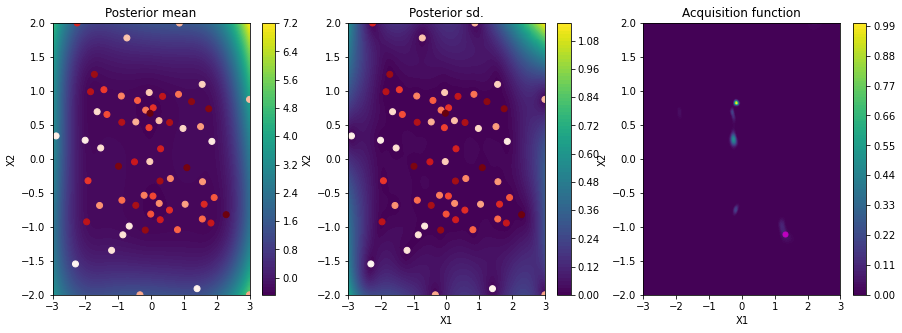

In [49]:
opt.plot_acquisition()